In [1]:
!unzip images_comp.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/v/v_101.png      
  inflating: images/v/v_102.png      
  inflating: images/v/v_103.png      
  inflating: images/v/v_104.png      
  inflating: images/v/v_105.png      
  inflating: images/v/v_106.png      
  inflating: images/v/v_107.png      
  inflating: images/v/v_108.png      
  inflating: images/v/v_109.png      
  inflating: images/v/v_11.png       
  inflating: images/v/v_110.png      
  inflating: images/v/v_111.png      
  inflating: images/v/v_112.png      
  inflating: images/v/v_113.png      
  inflating: images/v/v_114.png      
  inflating: images/v/v_115.png      
  inflating: images/v/v_116.png      
  inflating: images/v/v_117.png      
  inflating: images/v/v_118.png      
  inflating: images/v/v_119.png      
  inflating: images/v/v_12.png       
  inflating: images/v/v_120.png      
  inflating: images/v/v_121.png      
  inflating: images/v/v_122.png      
  inflating: images/v/v_123.png      

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

# Define class mapping to ensure correct LaTeX labels
CLASS_MAPPING = {
    'div': r'\div',
    'frac': r'\frac',
    'geq': r'\geq',
    'infty': r'\infty',
    'int': r'\int',
    'leq': r'\leq',
    'lessthan': '<',
    'morethan': '>',
    'pi': r'\pi',
    'pm': r'\pm',
    'theta': r'\theta',
    'times': r'\times'
}

class MathSymbolDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Collect images and labels
        self.images = []
        self.labels = []

        # Iterate through subdirectories
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                # Get correct label (use mapping if exists, else use folder name)
                label = CLASS_MAPPING.get(folder, folder)

                # Collect image paths for this class
                for img_name in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(label)

        # Create label to index mapping
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set(self.labels)))}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        label = self.label_to_idx[self.labels[idx]]
        return image, label

class MathSymbolCNN(nn.Module):
    def __init__(self, num_classes):
        super(MathSymbolCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def train_model(root_dir, save_dir, batch_size=64, epochs=20, learning_rate=0.001):
    # Data transformations
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Create dataset and dataloader
    dataset = MathSymbolDataset(root_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # Determine device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize model, loss, and optimizer
    model = MathSymbolCNN(len(dataset.label_to_idx)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            total_loss += loss.item()

        # Print epoch statistics
        epoch_loss = total_loss / len(dataloader)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # Save model checkpoint
        if((epoch + 1) % 10 == 0):
            checkpoint_path = os.path.join(save_dir, f'math_symbol_cnn_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
                'accuracy': accuracy,
                'label_mapping': dataset.label_to_idx
            }, checkpoint_path)

    # Save final model with label mapping
    final_model_path = os.path.join(save_dir, 'final_math_symbol_cnn.pth')
    torch.save({
        'model_state_dict': model.state_dict(),
        'label_mapping': dataset.label_to_idx,
        'idx_to_label': dataset.idx_to_label
    }, final_model_path)

    print(f"Training complete. Models and checkpoints saved in {save_dir}")
    return model, dataset.label_to_idx, dataset.idx_to_label

# Example usage
if __name__ == "__main__":
    # Update these paths for your Google Colab environment
    image_dir = '/content/images'  # Directory containing symbol image subfolders
    save_dir = '/content/drive/MyDrive/math_cnn_chkpts'

    # Train the model
    model, label_to_idx, idx_to_label = train_model(image_dir, save_dir)

Using device: cuda
Epoch [1/20], Loss: 1.1451, Accuracy: 67.10%
Epoch [2/20], Loss: 0.2915, Accuracy: 90.79%
Epoch [3/20], Loss: 0.1745, Accuracy: 94.61%
Epoch [4/20], Loss: 0.1290, Accuracy: 96.01%
Epoch [5/20], Loss: 0.1036, Accuracy: 96.80%
Epoch [6/20], Loss: 0.0864, Accuracy: 97.33%
Epoch [7/20], Loss: 0.0744, Accuracy: 97.67%
Epoch [8/20], Loss: 0.0643, Accuracy: 98.00%
Epoch [9/20], Loss: 0.0576, Accuracy: 98.30%
Epoch [10/20], Loss: 0.0536, Accuracy: 98.32%
Epoch [11/20], Loss: 0.0435, Accuracy: 98.76%
Epoch [12/20], Loss: 0.0456, Accuracy: 98.65%
Epoch [13/20], Loss: 0.0395, Accuracy: 98.84%
Epoch [14/20], Loss: 0.0427, Accuracy: 98.71%
Epoch [15/20], Loss: 0.0409, Accuracy: 98.80%
Epoch [16/20], Loss: 0.0345, Accuracy: 98.96%
Epoch [17/20], Loss: 0.0294, Accuracy: 99.12%
Epoch [18/20], Loss: 0.0316, Accuracy: 99.05%
Epoch [19/20], Loss: 0.0301, Accuracy: 99.14%
Epoch [20/20], Loss: 0.0310, Accuracy: 99.09%
Training complete. Models and checkpoints saved in /content/drive/MyDr

C:\Users\Aroshish\AppData\Local\Temp\ipykernel_22500\231400908.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


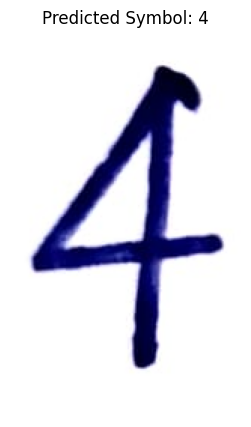

Predicted Symbol: 4


In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

class MathSymbolCNN(nn.Module):
    def __init__(self, num_classes):
        super(MathSymbolCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def predict_math_symbol(image_path, model_path):
    # Load the saved model and label mappings
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(model_path, map_location=device)

    # Prepare image transform
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Load and preprocess the image
    image = Image.open(image_path)
    transformed_image = transform(image).unsqueeze(0)  # Add batch dimension

    # Prepare the model
    model = MathSymbolCNN(len(checkpoint['idx_to_label']))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode

    # Get device
    
    model = model.to(device)
    transformed_image = transformed_image.to(device)

    # Perform prediction
    with torch.no_grad():
        outputs = model(transformed_image)
        _, predicted = torch.max(outputs, 1)
        predicted_idx = predicted.item()

    # Get the predicted label
    idx_to_label = checkpoint['idx_to_label']
    predicted_label = idx_to_label[predicted_idx]

    # Visualize the result
    plt.figure(figsize=(5,5))
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted Symbol: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

# Example usage
if __name__ == "__main__":
    # Update these paths for your environment
    image_path = 'C:\\Users\\Aroshish\\Downloads\\vbn.png'
    model_path = 'final_math_symbol_cnn.pth'

    # Predict and display the symbol
    result = predict_math_symbol(image_path, model_path)
    print(f"Predicted Symbol: {result}")